# Extract Weights and Visualize the Activations

In [1]:
import time
import torch
import itertools
import torchvision

import numpy as np
import torch.nn.functional as Functional
import matplotlib.pyplot as plt

from torch import nn, optim
from torchvision import datasets, transforms

from torch.utils.data import DataLoader

In [3]:
torch.manual_seed(13)

N_train = 64
N_test = 256

# We will use torch.utils.data.DataLoader to wrap our dataset.
# This provides easier batching, GPU support, etc.
# Calling torchvision.datasets.MNIST() will download and format the MNIST
# dataset with the transforms we specify. Here, in the transforms we first convert
# the image to PyTorch tensor, and then normalize the image based on a given mean
# and standard deviation. Normalizing the image does: image = (image - mean) / std.
# We shuffle the data as well by defining shuffle=True.

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=N_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=N_test, shuffle=False)

In [4]:
test_subset = enumerate(test_loader)
batch_idx, (one_batch_of_test_subset_x, one_batch_of_test_subset_y) = next(test_subset)

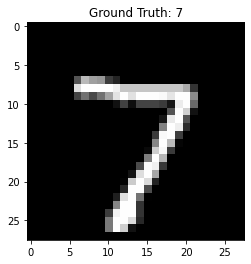

In [5]:
i = 0
plt.imshow(one_batch_of_test_subset_x[i][0], cmap='gray', interpolation='none')
_ = plt.title("Ground Truth: {}".format(one_batch_of_test_subset_y[i]))
number7 = one_batch_of_test_subset_x[i][0]

In [9]:
class CNN_A(nn.Module):
    def __init__(self):
        super(CNN_A, self).__init__()
        # We can define the arguments of each layer in the __init__ method.
        # __init__ method will be called everytime we create an object of this class.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # This is the forward pass function.
        # See how we can save the activation outputs of each layer into a variable.
        # In this case, we are saving the output of each layer
        # to the same variable and replacing the value every time
        # before sending to a new layers.
        
        # Conv -> MaxPool -> ReLU
        x = self.conv1(x)
        x = Functional.max_pool2d(x, 2)
        x = Functional.relu(x)
        
        # Conv -> MaxPool -> ReLU -> Dropout -> Flatten
        x = self.conv2(x)
        x = Functional.max_pool2d(x, 2)
        x = Functional.relu(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        
        # 3-layer MLP
        x = self.fc1(x)
        x = Functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = Functional.relu(x)      
        
        return x

In [11]:
model = torch.load('data/cnn_a_model.pt')

In [12]:
model

CNN_A(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

# Analysis of Weight Matrices/Parameters

In [13]:
def model_summary(model):
    """
    Returns the number of parameters (trainable and total) of a PyTorch model.
    """
    print("Trainable parameter variables: {}\nTotal number of parameters: {}\nTotal number of trainable parameters: {}".format(
        len(list(model.parameters())),
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad))
         )

In [14]:
model_summary(model)

Trainable parameter variables: 10
Total number of parameters: 232650
Total number of trainable parameters: 232650


In [15]:
# Extract the weights of the kernels of conv1 layer.
# We can later see how the weights vary per each layer.
kernels_conv1 = model.conv1.weight.cpu().detach().clone().numpy()

In [16]:
kernels_conv1.shape

(32, 1, 3, 3)

# Visualize Kernels

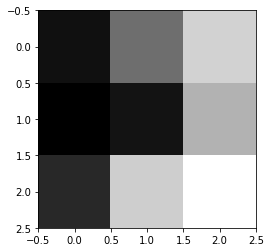

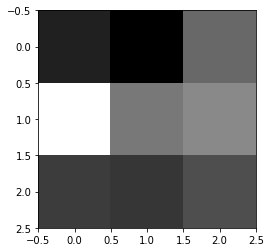

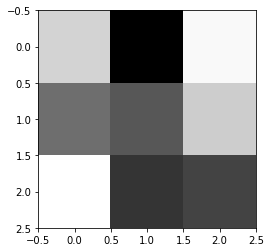

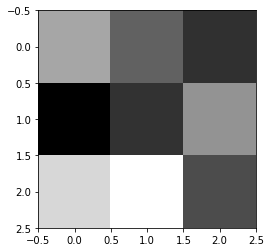

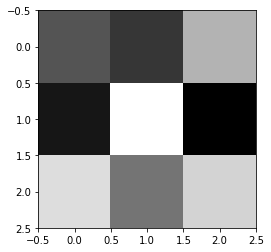

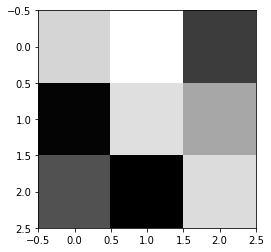

In [17]:
for _, i in enumerate(kernels_conv1):
    plt.imshow(i[0], cmap='gray')
    plt.show()
    if _==5:
        break

# Activation Maps

Similar to how we studied the embeddings in DNNs, in CNNs we are also interested in what kernels/filters the CNN had learnt during the optimization. To do so, we can do a forward pass by providing an input to the model and see what each kernels provide as an output. By visualizing these outputs, or activations, we can study (visually) what the network is learning. 

### Extract Conv1 layer activations

$$\frac{W-K+2P}{S} +1$$

- W is the input volume
- K is the kernel size
- P is the amount of padding
- S is the stride size

In [18]:
# Do a forward pass on the first convolution layer by passing
# the original MNIST image data to it.

conv1_activations = model.conv1.forward(number7.reshape(1,1,28,28)) # NCHW

# Alternate way to extract activations.
# conv1_layer = nn.Sequential(*list(model.children()))[0]
# conv1_activations = conv1_layer(number7.reshape(1,1,28,28))

Conv2 activations can be extracted by doing a forward pass on conv2 layer with conv1 activations as the input.

### Visualize the activations

In [19]:
conv1_activations.shape

torch.Size([1, 32, 26, 26])

In [20]:
np_act_conv1 = conv1_activations.detach().numpy()[0]

In [21]:
np_act_conv1.shape

(32, 26, 26)

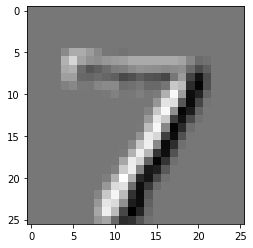

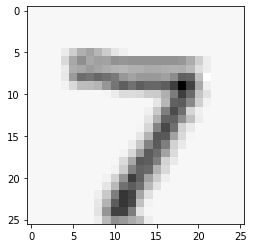

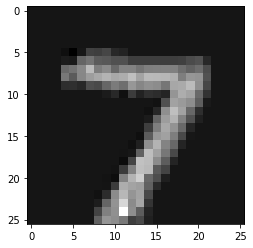

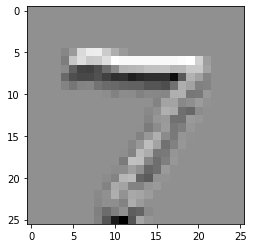

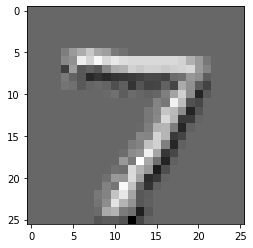

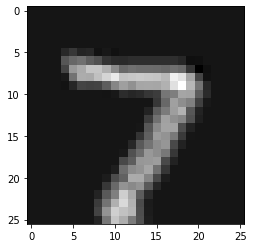

In [22]:
for _, i in enumerate(np_act_conv1):
    plt.imshow(i, cmap='gray')
    plt.show()
    if _==5:
        break

### Activations of Convolution Layer 1

In [23]:
conv1_activations = model.conv1.forward(number7.reshape(1,1,28,28))

In [24]:
pooling = nn.MaxPool2d(2)

In [25]:
c1_act_pool = pooling(conv1_activations)

In [26]:
c1_act_pool.shape

torch.Size([1, 32, 13, 13])

### Activations of Convolution Layer 2

In [27]:
conv2_activations = model.conv2.forward(c1_act_pool)

In [28]:
conv2_activations.shape

torch.Size([1, 64, 11, 11])

In [29]:
c2_act_pool = pooling(conv2_activations)

In [30]:
c2_act_pool.shape

torch.Size([1, 64, 5, 5])

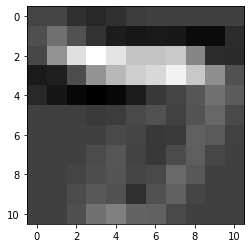

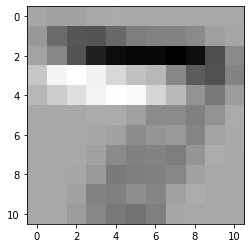

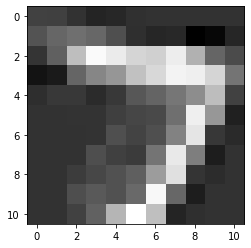

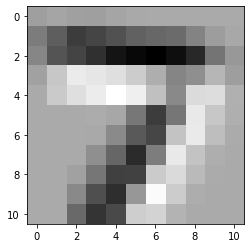

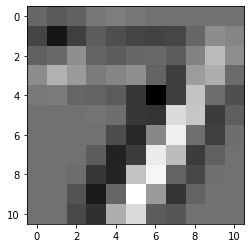

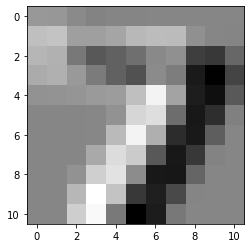

In [31]:
for _, i in enumerate(conv2_activations.detach().numpy()[0]):
    plt.imshow(i, cmap='gray')
    plt.show()
    if _==5:
        break

### Activations of 1st Dense Layer

In [32]:
fc1_out = model.fc1.forward(c2_act_pool.reshape(-1,))

In [33]:
fc1_out

tensor([-4.1456e+00, -4.9295e+00,  5.3709e+00, -5.8772e+00,  1.7997e+00,
        -1.3826e+00,  4.7123e+00, -8.2017e-01, -2.6194e+00, -4.5486e+00,
         8.2365e-01, -2.6392e+00, -3.2557e+00,  6.8869e-01,  8.2491e+00,
        -4.4091e+00,  4.4250e+00,  5.3392e+00, -3.3517e+00, -1.6754e-01,
         3.6478e+00, -3.2392e+00,  2.9307e-01,  1.9390e+00,  3.5782e+00,
        -5.1742e+00, -7.6724e-01, -6.1015e+00, -4.9951e+00, -1.5060e+00,
        -3.4631e+00, -5.7357e+00,  7.6498e-01,  8.1047e+00, -9.0717e-01,
         1.8494e+00, -4.1574e+00, -2.1536e+00,  3.2369e+00,  1.3346e+00,
         7.1353e+00,  4.7540e+00,  7.6866e+00, -5.4687e+00, -1.6188e+00,
         2.1785e+00,  7.0740e+00,  5.7414e+00, -2.8173e+00, -3.3035e+00,
         4.0159e+00, -5.4753e+00, -7.8575e-01, -1.3643e+00,  3.1427e+00,
        -1.3493e+00, -1.0876e+00,  2.6341e+00,  3.6669e-03, -3.0850e+00,
         3.6499e+00,  6.0771e+00, -4.4784e+00, -4.4080e+00, -9.0224e-01,
        -7.3338e+00,  4.5037e+00, -4.3768e-01,  2.2

In [34]:
relu = nn.ReLU()

In [35]:
fc1_out_relu = relu(fc1_out)

### Activations of 2nd Dense Layer

In [36]:
fc2_out = model.fc2.forward(fc1_out_relu)

In [37]:
# this is your embeddings!
fc2_out

tensor([-4.8212,  4.7807,  1.1886,  0.6397, -7.2577, -3.0935, -4.3722, -3.8728,
         1.9663,  4.5990,  2.2564, -4.1927, -7.1940,  2.2871, -3.3537,  1.5570,
         0.5815, -0.8630, -2.1706, -0.2657, -8.5961,  4.0978,  1.8740,  0.1265,
         0.2867, -1.3288, -6.8823, -3.2080,  6.8274,  3.9185,  1.0521,  0.6867,
         2.7179, -1.5931, -1.1426,  5.1409, -1.3734, -0.4973,  2.8816, -0.8617,
        -0.6568,  1.4401,  4.1535, -0.6556, -2.8151, -0.9458, -3.5407,  1.5130,
         1.3303, -1.8416, -5.2189, -3.1532, -0.8988, -5.4083, -1.7776,  1.8609,
         2.9317, -2.7245, -3.0302, -6.5645, -0.0355, -1.9984,  6.1867,  6.8262],
       grad_fn=<AddBackward0>)